In [68]:
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import boto3
from pycaret.regression import *

In [69]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
# pd.set_option('display.max_columns', 500)

In [71]:
ssl._create_default_https_context = ssl._create_unverified_context

# Tooling

### Upload S3

In [72]:
def UploadS3(filepath, key):
    s3 = boto3.client("s3")
    bucket_name = "economia-popular-delivery-content-indices"
    s3.upload_file(
        Filename=filepath,
        Bucket=bucket_name,
        Key=key,
        ExtraArgs={
            "ACL": "public-read",
            "ServerSideEncryption": "AES256"
        }
    )

    return True

# Forecasting de Indices Econômicos

In [73]:
df = pd.read_csv("https://economia-popular-delivery-content-indices.s3.amazonaws.com/inflacao/inflacao.csv")

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
df.columns

In [ ]:
df.shape

In [74]:
df.head()

,referencia,ano,mes,ano_mes,ipca_variacao,ipca_variacao_alimentacao,ipca_variacao_habitacao,ipca_variacao_artigos_residencia,ipca_variacao_vestuario,ipca_variacao_transporte,...,incc_m_variacao,incc_m_acumulado_ano,selic_meta,selic_ano,juros_reais,salario_minimo,pib_valor,divida_publica_pib,dolar_cambio,consolidado_ano
0,1980-01-01,1980,1,198001,6.62,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.579600e-11,False
1,1980-02-01,1980,2,198002,4.62,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.624000e-11,False
2,1980-03-01,1980,3,198003,6.04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.684400e-11,False
3,1980-04-01,1980,4,198004,5.29,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.749800e-11,False
4,1980-05-01,1980,5,198005,5.70,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.803300e-11,False


In [75]:
df.tail()

,referencia,ano,mes,ano_mes,ipca_variacao,ipca_variacao_alimentacao,ipca_variacao_habitacao,ipca_variacao_artigos_residencia,ipca_variacao_vestuario,ipca_variacao_transporte,...,incc_m_variacao,incc_m_acumulado_ano,selic_meta,selic_ano,juros_reais,salario_minimo,pib_valor,divida_publica_pib,dolar_cambio,consolidado_ano
522,2023-07-01,2023,7,202307,0.12,-0.46,-1.01,0.04,-0.24,1.50,...,0.06,2.25,13.75,13.65,9.29,0,909181.8,59.53,4.8002,False
523,2023-08-01,2023,8,202308,0.23,-0.85,1.11,-0.04,0.54,0.34,...,0.24,2.49,13.25,13.19,8.20,0,921554.9,59.81,4.9041,False
524,2023-09-01,2023,9,202309,0.26,-0.71,0.47,-0.58,0.38,1.40,...,0.24,2.73,12.75,12.97,7.40,0,900048.4,59.97,4.9364,False
525,2023-10-01,2023,10,202310,0.24,0.31,0.02,0.46,0.45,0.35,...,0.00,0.00,12.75,12.65,7.47,0,927296.3,59.96,5.0642,False
526,2023-11-01,2023,11,202311,0.28,0.63,0.48,-0.42,-0.35,0.27,...,0.00,0.00,12.25,12.17,7.16,0,0.0,0.00,4.8977,False


In [76]:
df['referencia'] = pd.to_datetime(df['referencia'], format='%Y-%m')

## IPCA - Câmbio

In [77]:
df_ipca = pd.DataFrame(data=df.dolar_cambio.values, index=df.referencia, columns=["value"])

In [78]:
df_ipca.head()

,value
referencia,
1980-01-01,1.579600e-11
1980-02-01,1.624000e-11
1980-03-01,1.684400e-11
1980-04-01,1.749800e-11
1980-05-01,1.803300e-11


In [79]:
df_ipca.tail(15)

,value
referencia,
2022-09-01,5.2364
2022-10-01,5.2497
2022-11-01,5.2741
2022-12-01,5.2418
2023-01-01,5.2001
2023-02-01,5.1711
2023-03-01,5.2109
2023-04-01,5.0191
2023-05-01,4.9822


In [80]:
df_ipca = df_ipca[df_ipca.index >= "2015-01-01"]

In [81]:
train = df_ipca[df_ipca.index <= "2023-06-01"]
train.shape

(102, 1)

In [82]:
test = df_ipca[df_ipca.index >= "2023-06-01"]
test.shape

(6, 1)

In [86]:
test.head()

,value
referencia,
2023-06-01,4.8510
2023-07-01,4.8002
2023-08-01,4.9041
2023-09-01,4.9364
2023-10-01,5.0642


## PyCaret Regression

In [85]:
from pycaret.regression import *

In [90]:
s = setup(data = train, test_data = test, target = 'value', fold_strategy = 'timeseries', numeric_features = ['value'], fold = 3, transform_target = True, session_id = 123)

ValueError: 

Column(s): ['value'] not found in the feature dataset!
They are either missing from the features or you have specified a target column as a feature. Available feature columns are:
[]

## PyCaret Apply

In [83]:
from pycaret.time_series import TSForecastingExperiment
from pycaret.time_series import setup
s = TSForecastingExperiment()

In [84]:
# train['Period']  = train.index

In [58]:
train

,value
referencia,
2015-01-01,2.6336
2015-02-01,2.8158
2015-03-01,3.1389
2015-04-01,3.0426
2015-05-01,3.0611
...,...
2023-02-01,5.1711
2023-03-01,5.2109
2023-04-01,5.0191


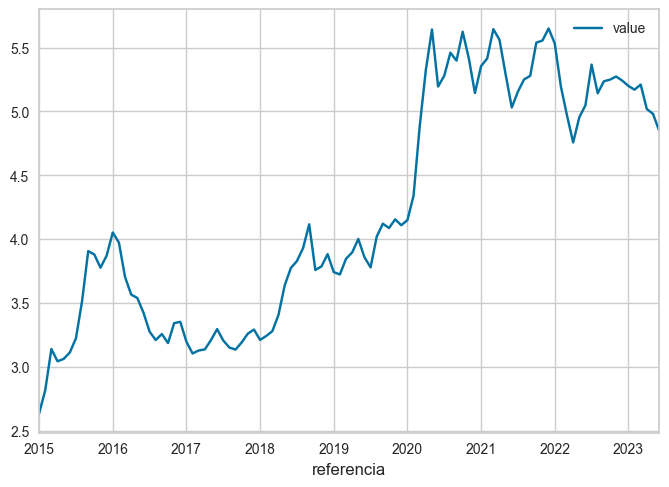

In [59]:
train.plot();

In [60]:
exp_name = s.setup(train, session_id = 123)

,Description,Value
0,session_id,123
1,Target,value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(102, 1)"
5,Transformed data shape,"(102, 1)"
6,Transformed train set shape,"(101, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [61]:
best = exp_name.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
arima,ARIMA,0.6324,0.4880,0.0848,0.0848,0.0168,0.0166,0.0233
auto_arima,Auto ARIMA,0.6557,0.5059,0.0879,0.0879,0.0174,0.0172,0.1100
naive,Naive Forecaster,0.6672,0.5149,0.0895,0.0895,0.0178,0.0175,0.0233
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.6950,0.5362,0.0931,0.0931,0.0186,0.0182,0.0300
exp_smooth,Exponential Smoothing,0.7277,0.5616,0.0976,0.0976,0.0194,0.0191,0.0167
ets,ETS,0.7278,0.5617,0.0976,0.0976,0.0194,0.0191,0.0100
theta,Theta Forecaster,0.7351,0.5673,0.0986,0.0986,0.0196,0.0193,0.0067
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.7689,0.5931,0.1030,0.1030,0.0205,0.0200,0.0133
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.8051,0.6213,0.1079,0.1079,0.0215,0.0211,0.0233
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8243,0.6362,0.1105,0.1105,0.0221,0.0216,0.0167


In [62]:
# s.plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 6})

In [63]:
final_best = s.finalize_model(best)

In [64]:
ipca_pred = s.predict_model(best, fh = test.shape[0])

In [65]:
ipca_pred

,y_pred
2023-06,4.9684
2023-07,4.9549
2023-08,4.9415
2023-09,4.9283
2023-10,4.9152
2023-11,4.9024


In [66]:
test

,value
referencia,
2023-06-01,4.8510
2023-07-01,4.8002
2023-08-01,4.9041
2023-09-01,4.9364
2023-10-01,5.0642
2023-11-01,4.8977


## Plot IPCA 

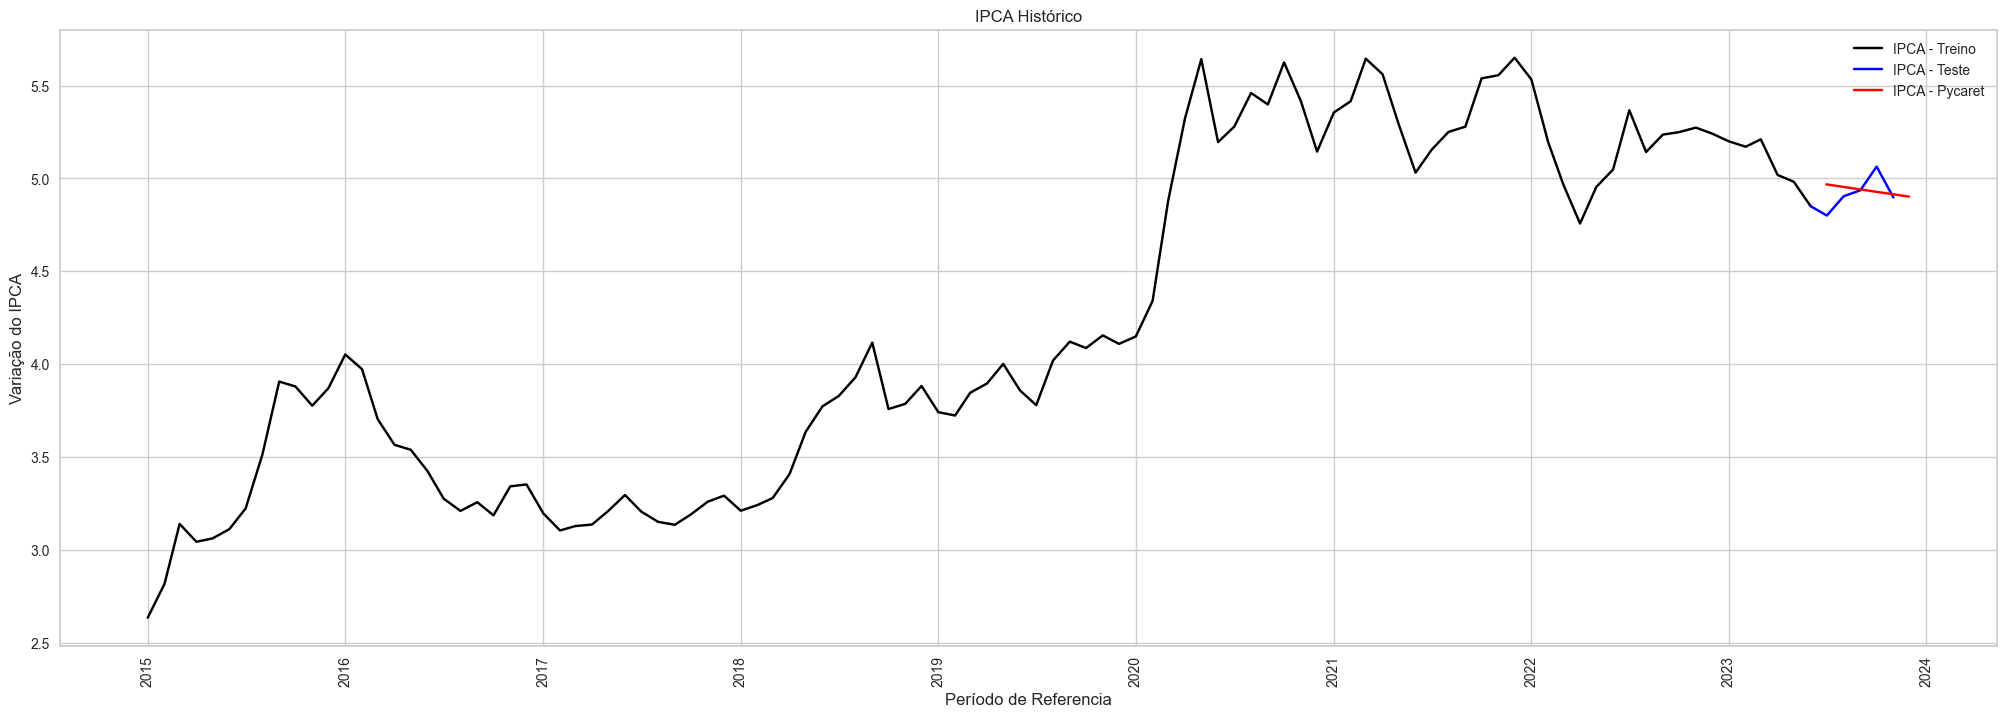

In [67]:
plt.figure(figsize=(25, 8))
plt.plot(train, label="IPCA - Treino", color='black')
plt.plot(test, label="IPCA - Teste", color='blue')
plt.plot(ipca_pred, label="IPCA - Pycaret", color='red')
plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.xticks(rotation=90)

plt.title("IPCA Histórico")
plt.legend()
plt.show()